# Predicting Movie Performance

I have compiled data for all the movies from 2011-2016 that had an opening US weekend box office total of $10m or more. We have some limited data points for each movie including genre, creative source, and production budget. Given the data for films from 2011-2015, can we predict the results of movies in 2016?

We'll be using a variety of decision tree techniques, including random forests and boosted trees.

In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
import pydot
import StringIO

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preparation
Here we'll be using pandas (http://pandas.pydata.org/) to import our data sets and ready our data for analysis. I've made sure that the data is already pretty normalized to make things easy on us.

However, scikit-learn doesn't support categorical features in its decision trees. We'll need to convert all of our categorical columns to numerical columns using one-hot encoding.

In [4]:
train = pd.read_csv('train.csv',parse_dates=[0])
trainY = train['Infl. Adj. Dom. Box Office']
del train['Infl. Adj. Dom. Box Office']

test = pd.read_csv('test.csv',parse_dates=[0])
testY = test['Infl. Adj. Dom. Box Office']
del test['Infl. Adj. Dom. Box Office']

train.head()
#trainY.head()

,Released,Title,Theatrical Distributor,Genre,Source,Production Method,Creative Type,Production Budget,Theatrical Engagements
0,2013-04-12,42,Warner Bros.,Drama,Based on Real Life Events,Live Action,Dramatization,40000000,21418
1,2013-08-02,2 Guns,Universal,Action,Based on Comic/Graphic Novel,Live Action,Contemporary Fiction,61000000,15505
2,2012-03-16,21 Jump Street,Sony Pictures,Comedy,Based on TV,Live Action,Contemporary Fiction,42000000,22744
3,2014-06-13,22 Jump Street,Sony Pictures,Comedy,Based on TV,Live Action,Contemporary Fiction,50000000,22821
4,2014-02-21,3 Days to Kill,Relativity,Thriller/Suspense,Original Screenplay,Live Action,Contemporary Fiction,28000000,11265


In [6]:
def onehot(train=train,test=test,column='Theatrical Distributor'):
    le = LabelEncoder()
    s = train[column]
    s = s.append(test[column])
    le.fit(s)
    s1 = le.transform(train[column])
    s2 = le.transform(test[column])
    a = np.append(s1,s2).reshape(-1,1)
    oh = OneHotEncoder(sparse=False)
    oh.fit(a)
    train_out = oh.transform(s1.reshape(-1,1))
    test_out = oh.transform(s2.reshape(-1,1))
    train_df = pd.DataFrame(train_out).rename(columns=lambda x: le.inverse_transform(x))
    test_df = pd.DataFrame(test_out).rename(columns=lambda x: le.inverse_transform(x))
    return (train_df, test_df)

In [7]:
trainX = pd.DataFrame()
trainX['budget'] = train['Production Budget']
trainX['theaters'] = train['Theatrical Engagements']

testX = pd.DataFrame()
testX['budget'] = test['Production Budget']
testX['theaters'] = test['Theatrical Engagements']
categorical_features = ['Theatrical Distributor', 'Genre', 'Source', 'Production Method', 'Creative Type']
for c in categorical_features:
    (t1,t2) = onehot(column=c)
    trainX = trainX.join(t1)
    testX = testX.join(t2)
trainX.head()

,budget,theaters,20th Century Fox,CBS Films,FilmDistrict,Focus / Gramercy,Focus Features,Lionsgate,Open Road,Paramount Pictures,...,Stop-Motion Animation,Contemporary Fiction,Dramatization,Factual,Fantasy,Historical Fiction,Kids Fiction,Multiple Creative Types,Science Fiction,Super Hero
0,40000000,21418,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,61000000,15505,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,42000000,22744,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,50000000,22821,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,28000000,11265,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Building Our First Decision Tree

In [8]:
regressor = DecisionTreeRegressor()
regressor.fit(trainX,trainY)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

## Visualizing A Tree

In [9]:
dotfile = StringIO.StringIO()
tree.export_graphviz(regressor, out_file=dotfile)
(graph,) = pydot.graph_from_dot_data(dotfile.getvalue())
graph.write_png("tree.png")

True

![Tree](tree.png)

In [45]:
def print_decision_path(tree,example):
    for decision in tree.decision_path(example).indices:
        print 'Node #{}: avg = ${:.2f}M'.format(decision,
                                              tree.tree_.value[decision][0][0]/1e6)
        print '\t decision = {} > {}? ... example_value = {}'.format(trainX.columns[tree.tree_.feature[decision]],
                                                          tree.tree_.threshold[decision],
                                                          example[trainX.columns[tree.tree_.feature[decision]]])

In [46]:
print train.iloc[25]
print '----------------------'
print_decision_path(regressor,trainX.iloc[25])

Released                           2015-07-17 00:00:00
Title                                          Ant-Man
Theatrical Distributor                     Walt Disney
Genre                                           Action
Source                    Based on Comic/Graphic Novel
Production Method                          Live Action
Creative Type                               Super Hero
Production Budget                            130000000
Theatrical Engagements                           25916
Name: 25, dtype: object
----------------------
Node #0: avg = $111.06M
	 decision = theaters > 21001.0? ... example_value = 25916.0
Node #626: avg = $228.99M
	 decision = theaters > 35699.0? ... example_value = 25916.0
Node #627: avg = $209.63M
	 decision = budget > 188750000.0? ... example_value = 130000000.0
Node #628: avg = $187.41M
	 decision = theaters > 30147.5? ... example_value = 25916.0
Node #629: avg = $172.04M
	 decision = budget > 122500000.0? ... example_value = 130000000.0
Node #713: av

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


## Evaluating The Tree

In [30]:
regressor.score(trainX,trainY)

1.0

In [31]:
regressor.score(testX,testY)

0.72551109823770032

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

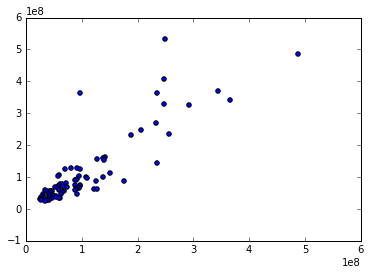

In [54]:
plt.scatter(regressor.predict(testX),testY)

In [63]:
print 'Root Mean Square Error = ${:.2f}M'.format(np.sqrt(np.mean(np.power(testY-regressor.predict(testX),2)))/1e6)
from sklearn import metrics
print metrics.explained_variance_score(testY,regressor.predict(testX))

Root Mean Square Error = $55.40M
0.750999539102


## Can We Do Better?
### Option 1: Tune Tree Parameters

### Option 2: Use A Different Algorithm

In [58]:
random_forest = RandomForestRegressor()
random_forest.fit(trainX,trainY)
print 'Test R^2 = {:.4f}'.format(random_forest.score(testX,testY))
print 'RMSE = ${:.2f}M'.format(np.sqrt(np.mean(np.power(testY-random_forest.predict(testX),2)))/1e6)

Test R^2 = 0.7802
RMSE = $51.37M


In [62]:
random_forest.feature_importances_

array([  9.81670741e-02,   8.06360645e-01,   1.88146331e-03,
         2.88403263e-05,   2.04899308e-06,   0.00000000e+00,
         3.71387079e-05,   1.05409831e-02,   4.78440662e-05,
         2.46720106e-03,   3.26629438e-04,   1.82796196e-06,
         1.91288060e-03,   6.09325973e-04,   4.76176415e-03,
         7.34344954e-03,   2.14633277e-03,   3.34995346e-05,
         2.88156394e-05,   5.94622162e-03,   1.83940690e-03,
         2.06681716e-05,   2.03244004e-03,   1.39716155e-05,
         8.22432413e-07,   3.29505632e-03,   4.60783909e-04,
         1.74370205e-04,   6.23722787e-04,   1.27808000e-03,
         1.26288785e-04,   4.43186756e-03,   5.61384994e-04,
         2.51546039e-03,   1.46619252e-04,   2.29870558e-05,
         0.00000000e+00,   2.26725596e-04,   3.40196748e-04,
         1.01923614e-05,   8.15710909e-05,   4.92488607e-04,
         2.14684556e-06,   1.37085226e-04,   2.20969196e-03,
         5.25760779e-04,   2.85168686e-03,   6.97088344e-03,
         8.13914665e-03,

In [59]:
gradient_boost = GradientBoostingRegressor()
gradient_boost.fit(trainX,trainY)
print 'Test R^2 = {:.4f}'.format(gradient_boost.score(testX,testY))
print 'RMSE = ${:.2f}M'.format(np.sqrt(np.mean(np.power(testY-gradient_boost.predict(testX),2)))/1e6)

Test R^2 = 0.8532
RMSE = $41.98M
